# How resilient are our models?
If we take many (>30) classifications of a galaxy and randomly pick 30, what model do we get, and how does this vary depending on the classifications we pick?

*This script has been copied to run on all galaxies in `model-variance-exploration.py`*

First, load up our environment!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import ShuffleSplit
from shapely.geometry import MultiPolygon
from descartes import PolygonPatch
import lib.galaxy_utilities as gu
import lib.python_model_renderer.parse_annotation as pa
import average_shape_helpers as ash
import get_average_shape as gas
from gzbuilderspirals import get_drawn_arms
from gzbuilderspirals.oo import Pipeline

Now grab all classifications for our galaxy (need a galaxy from the validation subset in order to have the required number of classifications for the shuffle split)

In [3]:
dr8ids, ss_ids, validation_ids = np.load('lib/duplicate_galaxies.npy').T
ss_id, val_id = ss_ids[94], validation_ids[42]
print('Original id:', ss_id)
print('Validation id:', val_id)

Original id: 20902040
Validation id: 21686557


In [4]:
all_cls = gu.classifications.query(
    '(subject_ids == {}) or (subject_ids == {})'.format(
        ss_id, val_id
    )
)
all_models = all_cls['annotations']\
    .apply(json.loads)\
    .apply(ash.remove_scaling)\
    .apply(pa.parse_annotation)
all_geoms = pd.DataFrame(
    all_models.apply(gas.get_geoms).values.tolist(),
    columns=('disk', 'bulge', 'bar')
)

For the purposes of demonstration, use 10 splits. `model-variance-exploration.py` uses 20 splits but takes ~4 hours to run.

In [5]:
N_SPLITS = 5

Now calculate the models for each of the splits, and save the results as a DataFrame

In [6]:
ss = ShuffleSplit(n_splits=N_SPLITS, test_size=0.5, random_state=0)
split_models = []
pas = []

gal, angle = gu.get_galaxy_and_angle(ss_id)

for i, (train_index, _) in enumerate(ss.split(all_geoms)):
    print('Split {}/{}'.format(i+1, N_SPLITS))
    models = all_models.iloc[train_index]
    drawn_arms = get_drawn_arms((ss_id, val_id), all_cls.iloc[train_index])
    if len(drawn_arms) > 0:
        p = Pipeline(drawn_arms, phi=angle, ba=gal['PETRO_BA90'],
                     image_size=512, parallel=True)
        pas.append(p.get_pitch_angle(p.get_arms()))
    else:
        pas.append((np.nan, np.nan))
    geoms = all_geoms.iloc[train_index]
    labels = list(map(np.array, gas.cluster_components(geoms)))
    aggregate_disk, aggregate_bulge, aggregate_bar = gas.get_aggregate_components(
        geoms, models, labels
    )
    split_models.append({
        'disk': aggregate_disk if aggregate_disk else None,
        'bulge': aggregate_bulge if aggregate_bulge else None,
        'bar': aggregate_bar if aggregate_bar else None,
    })

Split 1/5
Split 2/5
Split 3/5
Split 4/5
Split 5/5


In [7]:
splits_df = []
for model in split_models:
    model_comps = {}
    for key in ('disk', 'bulge', 'bar'):
        if model.get(key, None) is None:
            model[key] = {}
        mu = model[key].get('mu', (np.nan, np.nan))
        model_comps['{}-mux'.format(key)] = mu[0]
        model_comps['{}-muy'.format(key)] = mu[1]
        for param in ('roll', 'rEff', 'axRatio', 'i0', 'n', 'c'):
            model_comps['{}-{}'.format(key, param)] = (
                model[key].get(param, np.nan)
            )
    splits_df.append(model_comps)
splits_df = pd.DataFrame(splits_df)

In [8]:
pas = pd.DataFrame(
    pas,
    columns=('pa', 'sigma_pa'),
    index=pd.Series(range(len(pas)), name='split_index')
)
pas.describe().loc[['mean', 'std']]

,pa,sigma_pa
mean,19.428581,1.216343
std,4.195982,0.406637


In [9]:
split_geoms = list(map(gas.get_geoms, split_models))

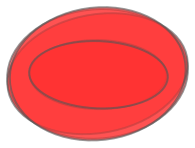

In [10]:
disks = [i[0] for i in split_geoms]
MultiPolygon(disks)

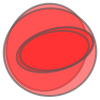

In [11]:
bulges = [i[1] for i in split_geoms]
MultiPolygon(bulges)

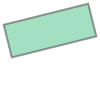

In [12]:
bars = [i[2] for i in split_geoms]
MultiPolygon(bars)

In [13]:
# splits_df.describe().transpose()[['count', 'mean', 'std']]

## Big picture

We've run this code on all galaxies in the validation subset, with 20 splits for each galaxy. What do the results show us?

In [14]:
files = [f for f in os.listdir('model-variances')
         if re.match(r'[0-9]+_.*?\.pickle', f)]

pas = [os.path.join('model-variances', f) for f in files if '_pa.' in f]
comps = [os.path.join('model-variances', f) for f in files if '_components.' in f]

pa_ids = [re.search(r'([0-9]+)_.*?', f).group(1) for f in pas]
comp_ids = [re.search(r'([0-9]+)_.*?', f).group(1) for f in pas]

In [15]:
pa_dfs = list(map(pd.read_pickle, pas))
comp_dfs = list(map(pd.read_pickle, comps))

### Pitch angle sample error

We'll look at pitch angle first. The big question is whether our predicted error on pitch angle from the model fit ties in with our observed variation from the classification splits

In [16]:
pa_details_df = pd.concat([
    pd.DataFrame(
        df.describe().loc[['mean', 'std']].values.T,
        index=['{}-pa'.format(i), '{}-sigma_pa'.format(i)],
        columns=['mean', 'std'],
    )
    for i, df in zip(pa_ids, pa_dfs)
])
pa_details_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 587726031710912518-pa to 587741600410632336-sigma_pa
Data columns (total 2 columns):
mean    158 non-null float64
std     150 non-null float64
dtypes: float64(2)
memory usage: 4.6+ KB


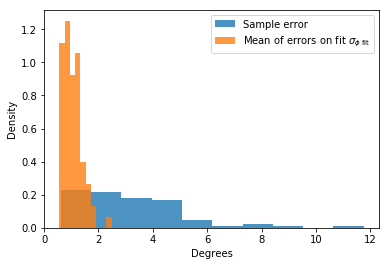

In [22]:
plt.hist(pa_details_df['std'].dropna().values[::2],
         density=True, alpha=0.8, label='Sample error');
plt.hist(pa_details_df['mean'].dropna().values[1::2],
         density=True, alpha=0.8, label=r'Mean of errors on fit $\sigma_{\phi\mathrm{\ fit}}$');
plt.legend();
plt.xlabel('Degrees')
plt.ylabel('Density')
plt.savefig('duplicates_plots/spiral-error-comparison.pdf', bbox_inches='tight')

Let's make a histogram of the mean fitted standard deviation minus the sample standard deviation of pitch angles

$$\overline{\sigma_{\phi\mathrm{\ fit}}} - \mathrm{s}_\phi$$

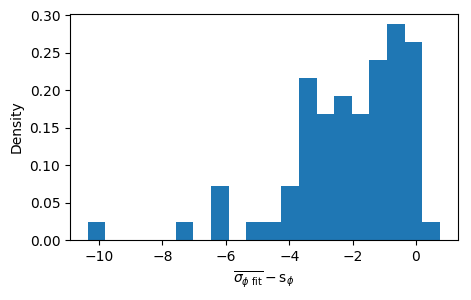

In [18]:
plt.figure(figsize=(5, 3), dpi=100)
plt.hist(
    pd.Series(pa_details_df['mean'].values[1::2] - pa_details_df['std'].values[::2]).dropna().values,
    bins=20, density=True,
)
plt.xlabel(r'$\overline{\sigma_{\phi\mathrm{\ fit}}} - \mathrm{s}_\phi$')
plt.ylabel('Density');

Looks like our fit is consistently under-reporting errors on the standard deviation, sometimes the sample error is 10° larger than the error on the fit.

## Model component sample error

Can we get a measure of the variance on our model parameters? Can we trust them at all?

Q: How often do our splits result in the same model?

*in the below plot, if volunteers always agreed on the components to use **and** the isophote of the components, we would see a bimodal distribution with points at either zero or one (either all models for a given galaxy have a component, or all do not)*

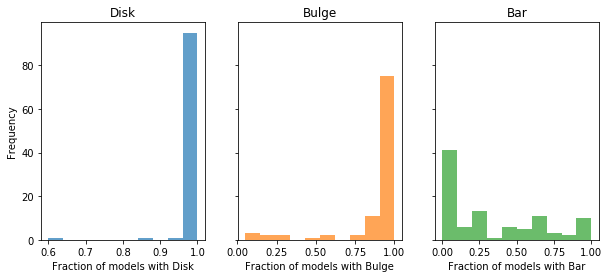

In [43]:
normalised_counts = pd.DataFrame([
    comp_dfs[i].count() / len(comp_dfs[i]) for i in range(len(comp_dfs))
])[['disk-axRatio', 'bulge-axRatio', 'bar-axRatio']]
fig, ax = plt.subplots(figsize=(10, 4), ncols=3, sharey=True)
for i, k in enumerate(('disk-axRatio', 'bulge-axRatio', 'bar-axRatio')):
    ax[i].hist(
        normalised_counts[k], density=False, alpha=0.7,
        label=k.split('-')[0], color='C{}'.format(i),
    )
    ax[i].set_title(k.split('-')[0].capitalize())
    ax[i].set_xlabel('Fraction of models with {}'.format(k.split('-')[0].capitalize()))
ax[0].set_ylabel('Frequency')
plt.savefig('duplicates_plots/model-consistency-comparison.pdf', bbox_inches='tight');

In [20]:
component_parameter_variances = pd.DataFrame([
    df['std']
    for df in 
    (
        comp_df.describe().transpose()
        for comp_df in comp_dfs
    )
], index=comp_ids)

/Users/tlingard/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


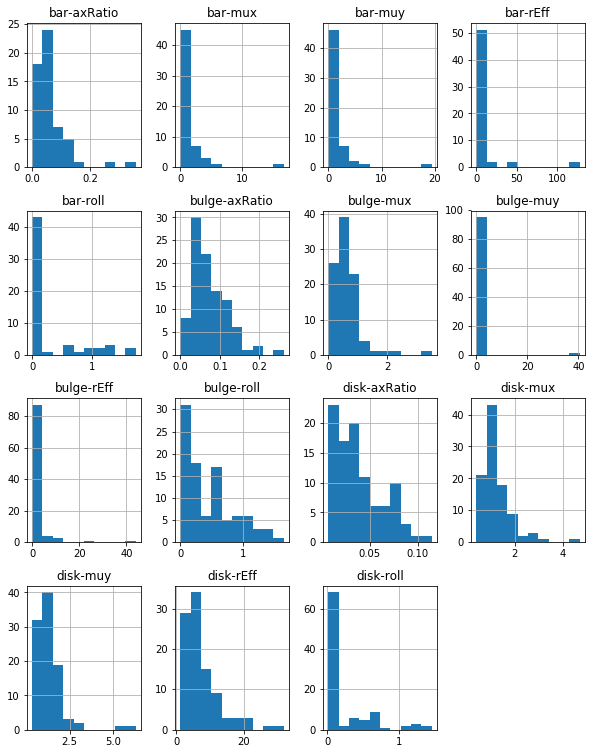

In [21]:
plt.figure(figsize=(10, 13))
component_parameter_variances.drop([
    'disk-i0', 'disk-n', 'disk-c',
    'bulge-i0', 'bulge-n', 'bulge-c',
    'bar-i0', 'bar-n', 'bar-c',
], axis=1).hist(ax=plt.gca());